# CMS Anomaly Detection

## Prepearing data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from joblib import Parallel, delayed

import re

DATA_PATH = 'merged.pickle'
SUBSYSTEM_LABELS_PATH = 'Quality2010'

The input files contains preselected features from CMS 2010B open data.
The features were generated from original root in following way:

1. There were selected 3 streams:
  - MiniBias,
  - muons,
  - photons.
2. In each stream 4 "channels" were selected:
  - muons
  - photons
  - PF (particle flows)
  - calo (calorimiter)
3. For each channel from each event  5 quantile particles were selected with redards to thier momentum: quantile $q_i$ corresponds to particle with index closest to $\frac{i}{5}N$, i.e. $q_5$ corresponds to the particle with maximal momentum.
4. Each particle is described by its physical properties: $\eta, \phi, p_T, f_x, f_y, f_z, m$
5. Physical features were aggragated by lumisections, producing:
  - 1, 25, 50, 75, 99 percentiles
  - mean and std
  
As the result each lumisection is described by percentiles, means and stds of distributions of physical features of particles of particular quantiles within particular channel within particular stream.

Some additional features were added like total momentum of all particles of particular channel within event

In [2]:
import cPickle as pickle

with open(DATA_PATH, 'r') as f:
    data = pickle.load(f)

labels = np.load('labels.npy')

In [3]:
def load_subsystem_labels(data_dir, name_patten=r'Cert_13TeV_2010_([a-zA-Z0-9]+)[.]txt'):
    import os
    import re
    import json

    pattern = re.compile(name_patten)
    
    labels = dict()
    
    for p in os.listdir(data_dir):
        name = pattern.findall(p)[0]

        with open(os.path.join(data_dir, p)) as f:
            data = json.load(f)
            
            good_data = set()
            
            for run in data:
                for a, b in data[run]:
                    a = int(a)
                    b = int(b)
                    
                    for lb in range(a, b + 1):
                        good_data.add((int(run), lb))
            
            labels[name] = good_data
    
    return labels

In [4]:
subsystem_labels_dict = load_subsystem_labels(SUBSYSTEM_LABELS_PATH)

In [5]:
subsystems = subsystem_labels_dict.keys()

In [6]:
subsystem_labels = np.zeros(shape=(len(data), len(subsystem_labels_dict)), dtype='float32')
indx = data[['_run', '_luminosityBlock']]

for i, sub_name in enumerate(subsystems):
    good_set = subsystem_labels_dict[sub_name]

    for j in xrange(len(data)):
        run, lumiblock = indx.iloc[j]
        
        subsystem_labels[j, i] = 1.0 if ((run, lumiblock) in good_set) else 0.0

In [7]:
subsystem_labels

array([[ 1.,  0.,  0., ...,  1.,  1.,  1.],
       [ 1.,  0.,  0., ...,  1.,  1.,  1.],
       [ 1.,  0.,  0., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  0., ...,  1.,  1.,  1.],
       [ 1.,  1.,  0., ...,  1.,  1.,  1.],
       [ 1.,  1.,  0., ...,  1.,  1.,  1.]], dtype=float32)

In [8]:
np.mean(np.min(subsystem_labels) == labels)

0.45384803921568628

In [9]:
for i in xrange(subsystem_labels.shape[1]):
    print "%s: %.3f" % (subsystems[i], np.mean(subsystem_labels[:, i] == labels))

Muon: 0.865
L1tcalo: 0.890
Hlt: 0.889
Ecal: 0.893
Track: 0.853
Lumi: 0.454
Csc: 0.853
Pix: 0.853
Rpc: 0.857
L1tmu: 0.890
Strip: 0.853
Hcal: 0.857
Egamma: 0.875
Jetmet: 0.875
Dt: 0.856
Es: 0.852


In [10]:
for i in xrange(subsystem_labels.shape[1]):
    s = subsystem_labels[:, i]
    print "%s: %.3f" % (subsystems[i], np.mean(labels[s == 0.0]))

Muon: 0.033
L1tcalo: 0.030
Hlt: 0.030
Ecal: 0.030
Track: 0.034
Lumi: 0.546
Csc: 0.034
Pix: 0.034
Rpc: 0.033
L1tmu: 0.030
Strip: 0.034
Hcal: 0.033
Egamma: 0.032
Jetmet: 0.032
Dt: 0.033
Es: 0.034


In [11]:
lumi = np.maximum(
    np.maximum(data['_instantLumi_minibias'].get_values(), data['_instantLumi_muons']).get_values(),
    data['_instantLumi_photons'].get_values()
)

In [12]:
### technical columns
not_features = [
    '_luminosityBlock',
    '_run',
    '_instantLumi_minibias',
    '_instantLumi_muons',
    '_instantLumi_photons'
]

### columns that correspond to actual features
features = sorted(set(data.columns) - set(not_features))

In [13]:
np.sum(np.isnan(data.values))

0

In [14]:
for f in features + ['_instantLumi_minibias', '_instantLumi_muons', '_instantLumi_photons']:
    xs = data[f].values

    if np.std(xs) > 0.0:
        data[f] = (xs - np.mean(xs)) / np.std(xs)

In [15]:
np.sum(np.isnan(data.values))

0

In [16]:
nonempty = np.where(lumi > 0.0)[0]

data = data.iloc[nonempty]
labels = labels[nonempty]
lumi = lumi[nonempty]
subsystem_labels = subsystem_labels[nonempty]

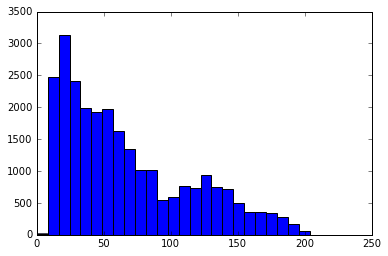

In [17]:
_ = plt.hist(lumi, bins=25)

In [18]:
data

,_instantLumi_minibias,_instantLumi_muons,_instantLumi_photons,_luminosityBlock,_run,minibias_PF_Px_mean,minibias_PF_Px_p1,minibias_PF_Px_p25,minibias_PF_Px_p50,minibias_PF_Px_p75,...,photons_photons_pt__q4_p75,photons_photons_pt__q4_p99,photons_photons_pt__q4_std,photons_photons_pt__q5_mean,photons_photons_pt__q5_p1,photons_photons_pt__q5_p25,photons_photons_pt__q5_p50,photons_photons_pt__q5_p75,photons_photons_pt__q5_p99,photons_photons_pt__q5_std
0,-0.476999,-0.461257,-0.474353,712.0,149442.0,0.553982,0.121924,-2.377744,2.979489,3.999278,...,0.764066,0.771053,0.613178,0.671934,-0.115348,0.529921,0.626325,0.669504,0.781640,0.624168
1,-0.477623,-0.461857,-0.474955,715.0,149442.0,0.618719,0.140093,-2.245878,3.164899,4.423358,...,0.816295,1.448301,0.720708,0.596897,-0.115348,0.500126,0.613411,0.762044,0.373972,0.564393
2,-0.477305,-0.461539,-0.474672,713.0,149442.0,0.590468,0.089144,-2.267943,3.180846,4.379818,...,1.024795,0.315584,0.565043,0.521407,-0.115348,0.398654,0.593673,0.525674,1.095464,0.607292
3,-0.477561,-0.461845,-0.474898,714.0,149442.0,0.563941,0.119073,-2.135948,3.271239,4.200118,...,1.010522,1.116072,0.778321,0.669518,-0.115348,0.659620,0.662089,0.603566,0.905891,0.494840
4,-0.538044,-0.523290,-0.535418,1023.0,149442.0,0.512639,0.077763,-2.699199,2.974805,4.191212,...,0.864409,0.397704,0.620604,0.533768,-0.115348,0.444284,0.585253,0.609742,1.004260,0.574727
5,-0.537828,-0.523068,-0.535225,1021.0,149442.0,0.517615,0.103767,-2.663293,2.657162,3.985256,...,0.648973,1.369331,0.777599,0.577041,-0.115348,0.526261,0.596193,0.478365,0.648295,0.346964
6,-0.537625,-0.522880,-0.535011,1022.0,149442.0,0.563187,0.102591,-2.438237,2.993670,4.275795,...,0.919552,0.240982,0.398985,0.444162,-0.115348,0.329574,0.505470,0.449276,0.451287,0.421262
7,-0.537408,-0.522655,-0.534744,1019.0,149442.0,0.505455,0.100209,-2.434321,3.207387,3.973735,...,0.938196,0.244517,0.423203,0.507372,-0.115348,0.346889,0.567593,0.525296,0.685222,0.375095
8,-0.537486,-0.522684,-0.534869,1020.0,149442.0,0.574270,0.096662,-1.984827,3.611923,4.527441,...,0.944487,0.125781,0.404884,0.529739,-0.115348,0.443858,0.608706,0.572331,0.111104,0.021400
9,1.853466,1.907932,1.857009,891.0,148862.0,0.143227,0.193403,-1.220393,-0.248370,0.592133,...,0.895971,0.757568,0.771628,0.576278,-0.115348,0.400897,0.583197,0.597291,0.727995,0.536766


## Grouping features

Feature set has its own intristic hierarchy. It can be easily seen from their names:
> `<stream>_<particle type>_<physical feature>_<particle quantile>_<feature quantile>`

We are going to build hierarchical Artificial Neural Network, so firstly we must bring features into hierarchy.

In [19]:
### utility functions
def insert(keys, d, f):
    key = keys[0]

    if len(keys) == 1:
        d[key] = f
    else:
        if not d.has_key(key):
            d[key] = dict()
        return insert(keys[1:], d[key], f)

def levels(features, n_levels = 5):
    dicts = [features]

    levels = list()

    for level in range(n_levels):
        levels.append(
            set([ k for d in dicts for k in d ])
        )
    
        dicts = [ d[k] for d in dicts for k in d ]
    return levels
    
def get_feature_groups(feature_list, re_exp):
    """
    Retuns:
    1. hierachical dictionary feature groups -> feature full name
    2. feature levels
    3. unprocessed features
        
    """
    features = dict()
    rest = list()
    n_levels = set()

    for f in feature_list:
        matches = re.findall(re_exp, f)

        if len(matches) == 1:
            insert(matches[0], features, f)
            n_levels.add(len(matches[0]))
        elif len(matches) == 0:
            rest.append(f)
        else:
            raise Exception('Very suspicious feature: %s -> %s' % (f, matches))
    assert len(n_levels) == 1
    return features, levels(features, n_levels=list(n_levels)[0]), rest

In [20]:
def insert_fake_path(d, level, path = 'general'):
    if level == 0:
        return { path : d }
    else:
        r = dict()
        for k in d:
            r[k] = insert_fake_path(d[k], level - 1, path)
        
        return r

### Selecting particles' features:
> `<stream>_<particle type>_<physical feature>_<particle quantile>_<feature quantile>`

In [21]:
particle_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]([a-zA-Z]+)[_]+(q[12345])[_](\w+)')
particle_features, particle_levels, rest = get_feature_groups(features, particle_f_re)

In [22]:
for level in particle_levels:
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
phi pt fX fY fZ eta mass
q1 q3 q2 q5 q4
std p99 p1 p25 p75 p50 mean


### Selecting features that belong to a particle type:
> `<stream>_<particle type>_<physical feature>_<feature quantile>`

In [23]:
particle_type_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]([a-zA-Z]+)[_]+([a-zA-Z0-9]+)')
particle_type_features, particle_type_levels, rest = get_feature_groups(rest, particle_type_f_re)

In [24]:
for level in particle_type_levels:
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
Pz Px Py
std p99 p1 p25 p75 p50 mean


In [25]:
particle_type_features = insert_fake_path(particle_type_features, level = 2, path='allParticles')

for level in levels(particle_type_features, n_levels=5):
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
allParticles
Pz Px Py
std p99 p1 p25 p75 p50 mean


The features above are components of momentum of particles of particular type (channel) within event.

### Selecting features specific to events:
> `<stream>_<physical feature>_<feature quantile>`

In [26]:
event_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]+(\w+)')
event_features, event_levels, rest = get_feature_groups(rest, event_f_re)

In [27]:
for level in event_levels:
    print ' '.join(list(level))

muons minibias photons
instantLumi
std p99 p1 p25 p75 p50 mean


In [28]:
f = insert_fake_path(event_features, level = 1, path='allChannels')
f = insert_fake_path(f, level = 2, path='allParticles')

event_features = f

for level in levels(event_features, n_levels=5):
    print ' '.join(list(level))

muons minibias photons
allChannels
allParticles
instantLumi
std p99 p1 p25 p75 p50 mean


Which are instant luminosity of each event.

In [29]:
rest

['minibias_nEvents',
 'minibias_nonZeroWeights',
 'muons_nEvents',
 'muons_nonZeroWeights',
 'photons_nEvents',
 'photons_nonZeroWeights']

### And finally features specific to lumisection itself:
> `<stream>_<physical feature>_<feature quantile>`

In [30]:
stream_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)')
stream_features, stream_levels, rest = get_feature_groups(rest, stream_f_re)

In [31]:
for level in stream_levels:
    print ' '.join(list(level))

muons minibias photons
nEvents nonZeroWeights


Number of events and fration of non-zero features for lumisection (all NA's are replaced with zeros).

In [32]:
rest

[]

In [33]:
from collections import defaultdict

def flatten(a_dict):
    for k in a_dict:
        if hasattr(a_dict[k], 'keys'):
            for path, value in flatten(a_dict[k]):
                yield (k, ) + path, value
        else:
            yield (k, ), a_dict[k]

def merge(dicts):
    result = dict()
    for d in dicts:
        for path, value in flatten(d):
            insert(path, result, value)

    return result

def flatten_dict(d):
    r = dict()
    for paths, v in flatten(d):
        k = '_'.join(paths)
        r[k] = v
    return r

def squezze(d, depth = 5, last=2):
    dc = d.copy()

    if depth - 1 == last:
        for k in d:
            dc[k] = flatten_dict(d[k])
        
        return d
    else:
        for k in d:
            dc[k] = squezze(d[k], depth-1, last)
        
        return dc

def group(d, level=2):
    gd = defaultdict(lambda: list())
    for path, k in flatten(d):
        gk = path[:level]
        gd[gk].append(k)
    
    return gd

In [34]:
feature_hierarchy = merge([
    particle_features, particle_type_features, event_features
])

In [35]:
grouped = group(feature_hierarchy, level=2)

In [36]:
len(grouped)

15

In [37]:
[ (g, len(fs)) for g, fs in grouped.items() ]

[((u'muons', u'photons'), 231),
 ((u'minibias', u'PF'), 126),
 ((u'photons', u'photons'), 231),
 ((u'minibias', u'calo'), 266),
 ((u'muons', u'muons'), 266),
 ((u'photons', u'muons'), 266),
 ((u'minibias', 'allChannels'), 7),
 ((u'photons', u'calo'), 266),
 ((u'photons', u'PF'), 126),
 ((u'muons', u'PF'), 126),
 ((u'minibias', u'photons'), 231),
 ((u'muons', 'allChannels'), 7),
 ((u'photons', 'allChannels'), 7),
 ((u'minibias', u'muons'), 266),
 ((u'muons', u'calo'), 266)]

In [38]:
channels = set([ k[1] for k in grouped ]) - set(['allChannels'])
print channels

set([u'muons', u'photons', u'PF', u'calo'])


In [39]:
for stream, channel in grouped.keys():
    if channel not in channels:
        for c in channels:
            grouped[(stream, c)].extend(grouped[(stream, channel)])
        del grouped[(stream, channel)]

In [40]:
[ (g, len(fs)) for g, fs in grouped.items() ]

[((u'muons', u'photons'), 238),
 ((u'minibias', u'PF'), 133),
 ((u'photons', u'photons'), 238),
 ((u'minibias', u'calo'), 273),
 ((u'muons', u'muons'), 273),
 ((u'photons', u'muons'), 273),
 ((u'photons', u'calo'), 273),
 ((u'photons', u'PF'), 133),
 ((u'muons', u'PF'), 133),
 ((u'minibias', u'photons'), 238),
 ((u'minibias', u'muons'), 273),
 ((u'muons', u'calo'), 273)]

## Building netwrok

In [41]:
%env THEANO_FLAGS='device=gpu0', 'floatX=float32'

import theano
import theano.tensor as T

from lasagne import *

import crayimage
from crayimage.nn import Expression

env: THEANO_FLAGS='device=gpu0', 'floatX=float32'


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [42]:
class AE(Expression):
    def __init__(self, n_input_features, nums_units=(50, 10)):
        X_batch = T.fmatrix('X')
        self.input = layers.InputLayer(shape=(None, n_input_features), input_var=X_batch)
        self.drop = layers.DropoutLayer(self.input, p=0.1)
        net = self.input
        
        for n in nums_units:
            net = layers.DenseLayer(net, num_units=n, nonlinearity=nonlinearities.sigmoid)
        
        code = layers.get_output(net, deterministic=True)
        self.code_layer = net
        
        for n in nums_units[:-1][::-1]:
            net = layers.DenseLayer(net, num_units=n, nonlinearity=nonlinearities.sigmoid)
        
        net = layers.DenseLayer(net, num_units=n_input_features, nonlinearity=nonlinearities.linear)
        self.net = net
        
        X_reconstructed = layers.get_output(net)
        X_reconstructed_det = layers.get_output(net, deterministic=True)
        self.X_reconstructed = X_reconstructed
        
        super(AE, self).__init__(self.input, self.net)
        
        weights = T.fvector('weights')
        reconstruction_error = T.sum((X_reconstructed - X_batch) ** 2, axis=1)
        reconstruction_error_det = T.sum((X_reconstructed_det - X_batch) ** 2, axis=1)

        mse_loss = T.sum(weights * reconstruction_error) / T.sum(weights)
        
        reg = regularization.regularize_network_params(net, regularization.l2)
        reg_C = T.fscalar('reg_c')
        
        loss = mse_loss + reg_C * reg
        
        learning_rate = T.fscalar('learning rate')
        params = layers.get_all_params(net)
        upd = updates.adadelta(loss, params, learning_rate=learning_rate)
        
        self.train = theano.function([X_batch, weights, reg_C, learning_rate], mse_loss, updates=upd)
        self.get_error = theano.function([X_batch], reconstruction_error_det)
        self.encode = theano.function([X_batch], code)
        
        given_code = T.fmatrix('given code')
        X_decoded = layers.get_output(net, inputs={self.code_layer : given_code})
        self.decode = theano.function([given_code], X_decoded)
    
    @staticmethod
    def batch_stream(X, weights, batch_size=32):
        indx = np.random.permutation(X.shape[0])
        n_batches = X.shape[0] / batch_size
        
        for i in xrange(n_batches):
            batch_indx = indx[(i * batch_size):(i * batch_size + batch_size)]
            yield X[batch_indx], weights[batch_indx]
    
    def fit(self, X, weights, n_epoches = 1, batch_size=32, learning_rate = 1.0, regularization_c = 1.0e-3):
        n_batches = X.shape[0] / batch_size
        
        learning_rate = np.float32(learning_rate)
        regularization_c = np.float32(regularization_c)
        
        losses = np.zeros(shape=(n_epoches, n_batches), dtype='float32')
        for epoch in xrange(n_epoches):
            batch_stream = self.batch_stream(X, weights, batch_size)
            
            for i, (X_batch, w_batch) in enumerate(batch_stream):
                assert np.sum(w_batch) > 0.0

                losses[epoch, i] = self.train(X_batch, w_batch, regularization_c, learning_rate)
            
            yield losses[:(epoch + 1)]

In [43]:
def plot_hist(xs, ws, n_bins=50,
              labels=tuple(), colors=('green', 'red', 'blue'),
              title='', xlabel='', legend_loc='upper right',
              vline=None):
    plt.figure(figsize=(12, 8))
    ws = [ w / np.sum(w) for w in ws ]
    hs, _, _ = plt.hist(
        xs, bins=n_bins, weights=ws, histtype='step', label=labels, color=colors[:len(xs)]
    )
    plt.title(title, fontsize=24)
    plt.xlabel(xlabel, fontsize=20)
    
    if vline is not None:
        plt.plot([vline, vline], [0.0, np.max([np.max(h) for h in hs])], '--', label='well reconstruction cut')
    
    plt.legend(loc=legend_loc)
    
    plt.show()

In [44]:
from sklearn.svm import OneClassSVM

Feature group ('muons', 'muons')
Mean field estimation error: 4.06e+01
AE error: 4.02e+00


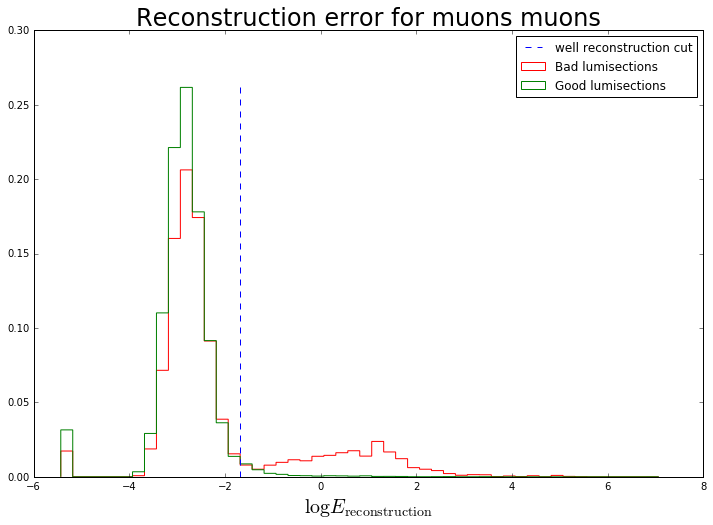

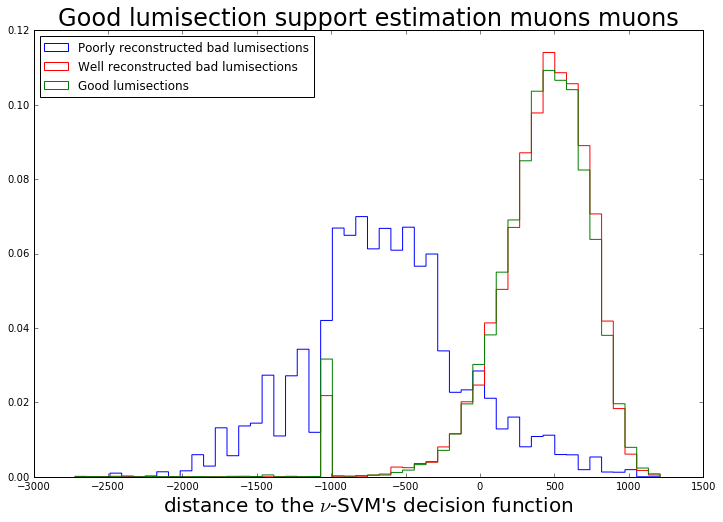

Feature group ('photons', 'photons')
Mean field estimation error: 4.48e+01
AE error: 3.97e+00


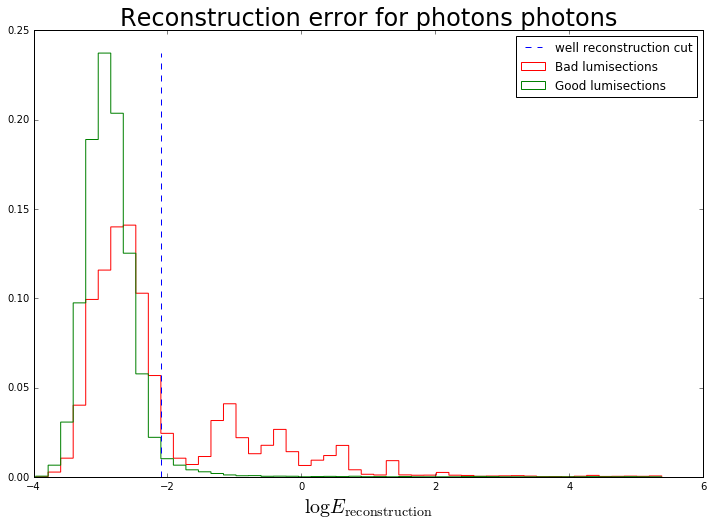

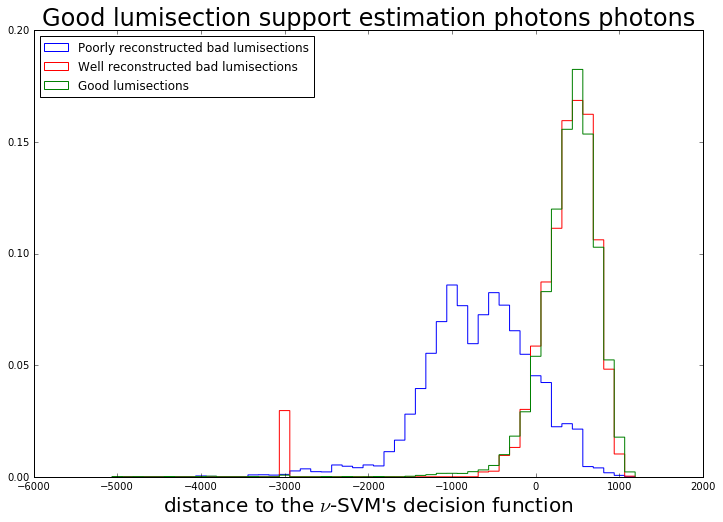

Feature group ('minibias', 'PF')
Mean field estimation error: 3.86e+01
AE error: 5.09e+00


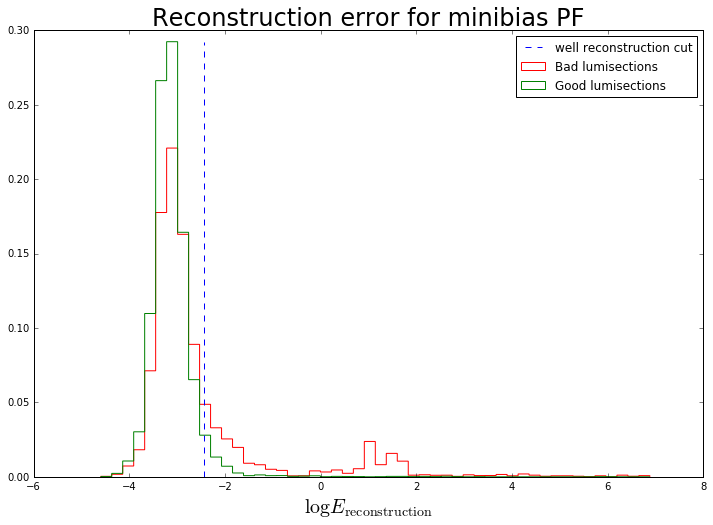

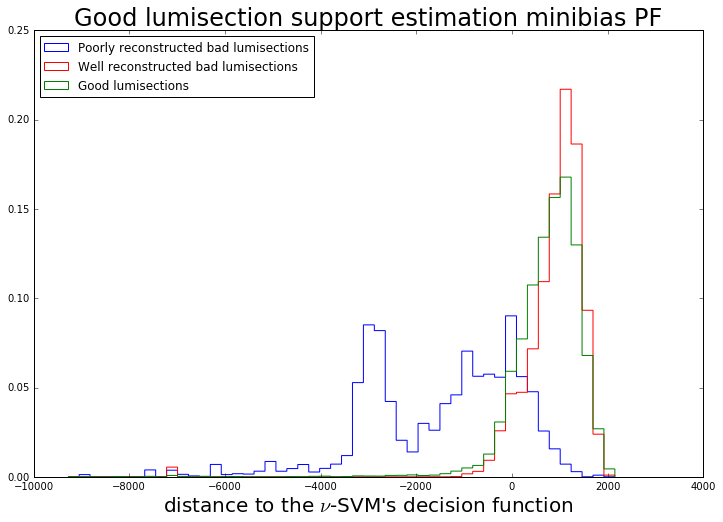

Feature group ('minibias', 'calo')
Mean field estimation error: 7.94e+01
AE error: 2.00e+01


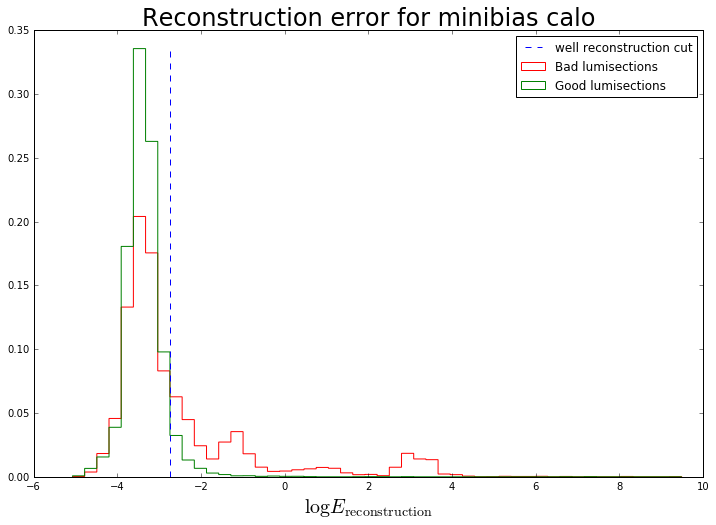

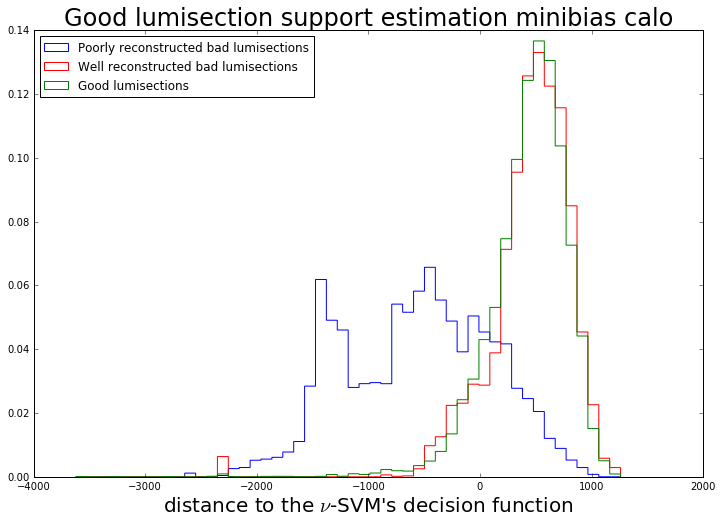

In [45]:
for g in [('muons', 'muons'), ('photons', 'photons'), ('minibias', 'PF'), ('minibias', 'calo')]:
    if len(g) < 1:
        continue

    X = data[grouped[g]].get_values().astype('float32')
    X_good = X[labels == 1.0]
    X_bad = X[labels == 0.0]
    
    weights_good = lumi[labels == 1.0].astype('float32')
    weights_bad = lumi[labels == 0.0].astype('float32')

    ae = AE(X.shape[1], nums_units=(150, 20))
    
    for l in ae.fit(X_good, weights_good, n_epoches=128,
                    batch_size=128, learning_rate=1.0,
                    regularization_c=1.0e-4):
        #print np.mean(l)
        pass
    
    X_mean = np.sum(weights_good[:, None] * X_good, axis=0) / np.sum(weights_good)
    mean_error = np.sum(np.sum((X_good - X_mean) ** 2, axis=1) * weights_good) / np.sum(weights_good)
    AE_error = np.sum(ae.get_error(X_good) * weights_good) / np.sum(weights_good)

    print 'Feature group', g
    print 'Mean field estimation error: %.2e' % mean_error
    print 'AE error: %.2e' % AE_error
    
    log_E_good = np.log(ae.get_error(X_good) / mean_error)
    log_E_bad = np.log(ae.get_error(X_bad) / mean_error)
    
    cut = np.percentile(log_E_good, q = 95)
    
    plot_hist(
        [log_E_good, log_E_bad], [weights_good, weights_bad],
        labels = ['Good lumisections', 'Bad lumisections'],
        xlabel = '$\log E_{\mathrm{reconstruction}}$',
        title = 'Reconstruction error for %s %s' % g,
        vline = cut
    )
    
    well_approximated_bad = log_E_bad < cut
    badly_approximated_bad = log_E_bad >= cut

    svm = OneClassSVM(nu=0.1, cache_size=128, gamma = 2.0 / X_good.shape[1])
    svm.fit(ae.encode(X_good), sample_weight=weights_good)
    
    score_good = svm.decision_function(ae.encode(X_good))[:, 0]
    score_bad = svm.decision_function(ae.encode(X_bad[well_approximated_bad]))[:, 0]
    score_badly_bad = svm.decision_function(ae.encode(X_bad[badly_approximated_bad]))[:, 0]
    
    plot_hist(
        [score_good, score_bad, score_badly_bad],
        [weights_good, weights_bad[well_approximated_bad], weights_bad[badly_approximated_bad]],
        labels=['Good lumisections', 'Well reconstructed bad lumisections', 'Poorly reconstructed bad lumisections'],
        title = 'Good lumisection support estimation %s %s' % g,
        xlabel = "distance to the $\\nu$-SVM's decision function",
        legend_loc='upper left'
    )

## Test against ground truth 

In [46]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [47]:
channels = [('muons', 'muons'), ('photons', 'photons'), ('minibias', 'PF'), ('minibias', 'calo')]
reconstruction_error = np.ndarray(shape=(len(data), len(channels)), dtype='float32')

for i, g in enumerate(channels):
    X = data[grouped[g]].get_values().astype('float32')
    X_good = X[labels == 1.0]
    X_bad = X[labels == 0.0]
    
    weights_good = lumi[labels == 1.0].astype('float32')
    weights_bad = lumi[labels == 0.0].astype('float32')

    ae = AE(X.shape[1], nums_units=(150, 20))
    
    for l in ae.fit(X_good, weights_good, n_epoches=256,
                    batch_size=128, learning_rate=1.0,
                    regularization_c=1.0e-4):
        #print np.mean(l)
        pass
    
    print 'AE for %s is fit' % (g, )
    
    reconstruction_error[:, i] = ae.get_error(X)

AE for ('muons', 'muons') is fit
AE for ('photons', 'photons') is fit
AE for ('minibias', 'PF') is fit
AE for ('minibias', 'calo') is fit


/home/mborisya/opt/miniconda/lib/python2.7/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


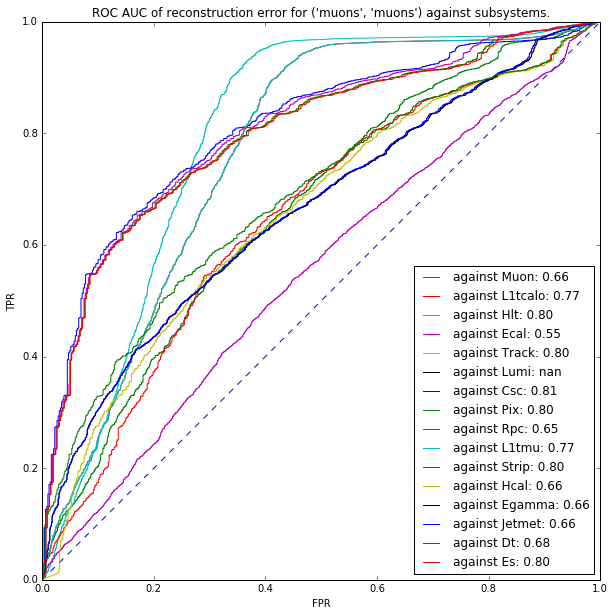

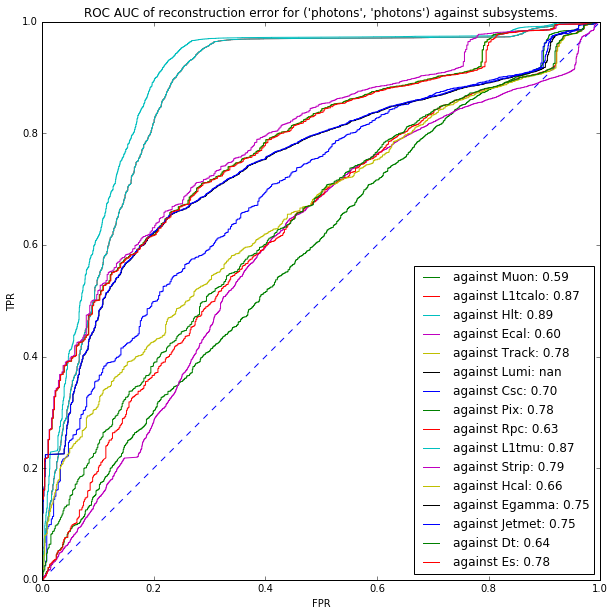

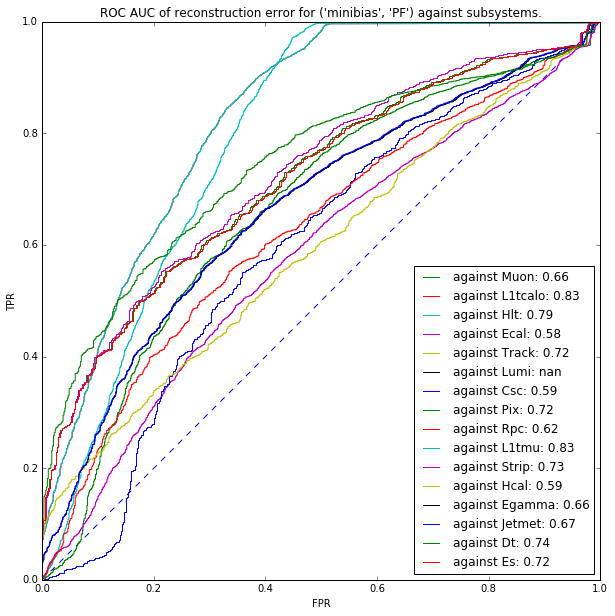

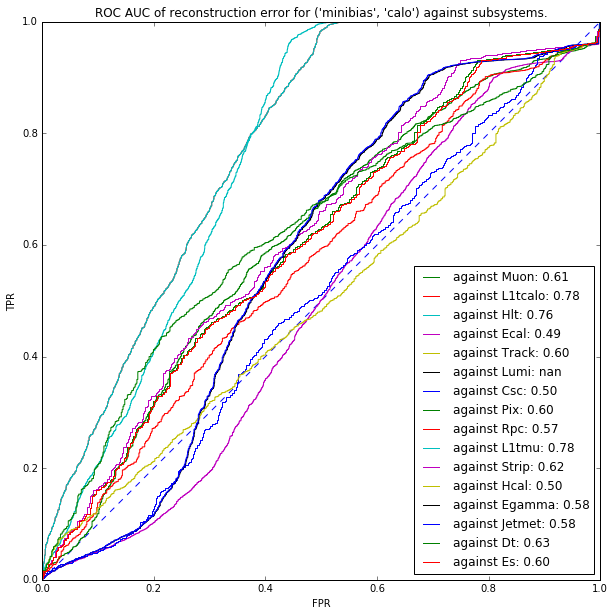

In [48]:
for i, g in enumerate(channels):
    plt.figure(figsize=(10, 10))
    plt.title('ROC AUC of reconstruction error for %s against subsystems.' % (g, ))
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    for j, sub in enumerate(subsystems):
        fpr, tpr, _ = roc_curve(subsystem_labels[:, j], -reconstruction_error[:, i])
        score = auc(fpr, tpr, reorder=True)
        plt.plot(fpr, tpr, label='against %s: %.2f' % (sub, score))
    plt.legend(loc='lower right')
    plt.show()

In [49]:
aucs = np.ones(shape=(reconstruction_error.shape[1], subsystem_labels.shape[1])) / 2.0

for i in xrange(reconstruction_error.shape[1]):
    for j in xrange(subsystem_labels.shape[1]):
        try:
            aucs[i, j] = roc_auc_score(subsystem_labels[:, j], -reconstruction_error[:, i])
        except:
            pass

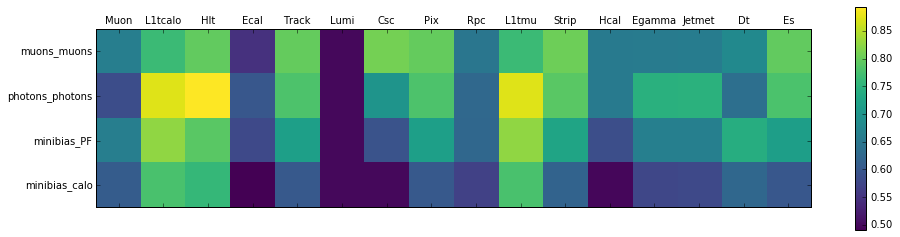

In [52]:
plt.figure(figsize=(12, 6))
plt.matshow(aucs, cmap=plt.cm.viridis)
plt.xticks(np.arange(len(subsystems)), subsystems)
plt.yticks(np.arange(4), [ "%s_%s" % g for g in channels ])
plt.colorbar()
plt.show()